In [1]:
import numpy as np
import pandas as pd
import csv
from scipy import stats
import os
import datetime
import sys
import time
import random
import json
import re
import pickle
from collections import Counter
import spacy
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from surprise import Dataset, Reader
from surprise import KNNWithMeans
from surprise.model_selection.split import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words.remove("full") # want to remove the word 'full' because 'full-bodied' is common
nlp.vocab["full"].is_stop = False # actually changes the characterization of the word "full"

In [3]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/avs-fallback-comp1/code/Users/asun/Whiskeys/Recommenders'

<br>

In [4]:
'''
https://www.offerzen.com/blog/how-to-build-a-content-based-recommender-system-for-your-product
https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243
https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4
https://towardsdatascience.com/introduction-to-two-approaches-of-content-based-recommendation-system-fc797460c18c 
https://towardsdatascience.com/lovecraft-with-natural-language-processing-part-3-tf-idf-vectors-8c2d4df98621 
https://medium.com/@toprak.mhmt/content-based-recommender-system-bdfc60b1bee8
'''

'\nhttps://www.offerzen.com/blog/how-to-build-a-content-based-recommender-system-for-your-product\nhttps://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243\nhttps://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4\nhttps://towardsdatascience.com/introduction-to-two-approaches-of-content-based-recommendation-system-fc797460c18c \nhttps://towardsdatascience.com/lovecraft-with-natural-language-processing-part-3-tf-idf-vectors-8c2d4df98621 \n'

## READ FILES AND INITIAL EXPLORE / TRANSFORM AND MAKE SURPRISE DS

In [5]:
file_dir = '../Data_Files/' 

df_revs_rec = pd.read_csv(file_dir + 'whisk_reviews_recommender.csv')
print(df_revs_rec.shape)
df_revs_rec.head()

(110610, 6)


,reviewer_name,reviewer_date,alc_name,alc_type,latest_avg_rating,latest_rev_date
0,----------451,"Tasted March 2, 2021",HIGHLAND PARK 12 YEAR,single_malt_peated,3.75,2021-03-02
1,----------451,"Tasted March 12, 2021",THE POGUES IRISH WHISKEY,ireland_whiskey,2.50,2021-03-12
2,----------451,"Tasted May 12, 2021",DALMORE 12 YEAR SHERRY CASK SELECT,single_malt,4.25,2021-05-12
3,----------96,"Tasted December 29, 2017",LAPHROAIG FOUR OAK,single_malt_peated,5.00,2017-12-29
4,----------96,"Tasted January 28, 2018",NIKKA BLENDED,japan_whiskey,2.00,2018-01-28


In [6]:
df_revs_rec['rev_ct'] = 1
df_revs_rec['rev_ct'] = df_revs_rec.groupby('reviewer_name')['rev_ct'].transform(sum)

# UNFORTUNATELY, NEED TO REMOVE REVIEWERS WITH <=2 TOTAL REVIEWS
df_revs_rec = df_revs_rec.loc[df_revs_rec['rev_ct'] >= 3]

In [7]:
# PACKAGE CALLED SURPRISE
reader = Reader(rating_scale=(0, 5))

# Loads Pandas dataframe
ds_revs_rec = Dataset.load_from_df(df_revs_rec[["reviewer_name", "alc_name", "latest_avg_rating"]], reader)
print(type(ds_revs_rec))

# SET THE RANDOM SEED FOR REPRODUCIBILITY
np.random.seed(776926)

# BREAK OUT INTO TRAINING, TEST
trainset, testset = train_test_split(ds_revs_rec, test_size=0.2)
print(type(trainset))
print(type(testset))

<class 'surprise.dataset.DatasetAutoFolds'>
<class 'surprise.trainset.Trainset'>
<class 'list'>


In [8]:
trainset_df = trainset.build_testset()
trainset_df = {'uid': [x[0] for x in trainset_df], 'iid': [x[1] for x in trainset_df], 'act': [x[2] for x in trainset_df]}
trainset_df = pd.DataFrame(trainset_df)
trainset_df.sample(5)

,uid,iid,act
68899,Jim-Callahan,JAMESON THE DISTILLER'S SAFE,3.75
12441,Alicia-D,ELIJAH CRAIG TOASTED BARREL BOURBON,4.25
62864,Whiskey_Pete,CONNEMARA CASK STRENGTH PEATED SINGLE MALT,3.00
46723,Lsc1257,JOURNEYMAN DISTILLERY FEATHERBONE ORGANIC BOURBON,4.00
52039,GoldnWlf,WILD TURKEY RARE BREED BARREL PROOF BOURBON,3.50


In [9]:
df_alc_types = df_revs_rec.loc[:,['alc_name', 'alc_type']].drop_duplicates().reset_index(drop = True)
df_alc_types.head()

,alc_name,alc_type
0,HIGHLAND PARK 12 YEAR,single_malt_peated
1,THE POGUES IRISH WHISKEY,ireland_whiskey
2,DALMORE 12 YEAR SHERRY CASK SELECT,single_malt
3,GLENFIDDICH 18 YEAR,single_malt
4,TULLAMORE D.E.W. 12 YEAR SPECIAL RESERVE,ireland_whiskey


In [106]:
df_revs_text = pd.read_csv(file_dir + 'whisk_reviews_combined.csv')
df_revs_text = df_revs_text.loc[:,['reviewer_name', 'reviewer_date', 'alc_name', 'reviewer_notes']]
df_revs_text = pd.merge(df_revs_rec, df_revs_text, how = "left", \
                        left_on = ['reviewer_name', 'reviewer_date', 'alc_name'], 
                        right_on = ['reviewer_name', 'reviewer_date', 'alc_name'])

# conver values to string
df_revs_text['reviewer_notes'] = [str(elem) for elem in df_revs_text['reviewer_notes']]

In [108]:
df_revs_text['combined_notes'] = df_revs_text.groupby(['alc_name'])['reviewer_notes'].transform(lambda x : ' '.join(x))
df_revs_text = df_revs_text.loc[:,['alc_name', 'combined_notes']].drop_duplicates().reset_index(drop = True)
print(df_revs_text.shape)
df_revs_text.head()

(3112, 2)


,alc_name,combined_notes
0,HIGHLAND PARK 12 YEAR,", , . \n , , , , , , , hel..."
1,THE POGUES IRISH WHISKEY,", , . \n , , . Surprisingly much be..."
2,DALMORE 12 YEAR SHERRY CASK SELECT,"!\n:\n , , , , .\n\n: , , ..."
3,GLENFIDDICH 18 YEAR,", , , , . . 12\n\n\n : \n : , milk chocol..."
4,TULLAMORE D.E.W. 12 YEAR SPECIAL RESERVE,. . Not as smooth as original but adde...


In [28]:
def get_tokens(x):
    tokens = nlp(x)
    token_vec = [re.sub('[^0-9a-zA-Z]+', '', token.lemma_.lower()) for token in tokens if \
                 (token.is_stop == False and \
                  token.is_punct == False and \
                  token.is_space == False and \
                  token.like_num == False and \
                  token.is_ascii == True 
                 )]
    
    return(token_vec)

In [29]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion, and I love full-bodied alcohol")
print(get_tokens("Apple is looking at buying U.K. startup for $1 billion, and I love full-bodied alcohol"))

['apple', 'look', 'buy', 'uk', 'startup', '', 'love', 'full', 'bodied', 'alcohol']


In [38]:
test_output = get_tokens(str(df_revs_text.loc[df_revs_text['alc_name'] == 'LAPHROAIG FOUR OAK', 'combined_notes']))
print(len(test_output))
print(test_output)
print(np.array(test_output)[np.where(np.array(test_output) == 'citrus')])

10
['kalt', 'etwas', 'salzig', 'smokey', 'bit', 'salty', 'ful', 'combinednote', 'dtype', 'object']
[]


In [39]:
tfidf_vectorizer = TfidfVectorizer(input = 'content', tokenizer = get_tokens, \
                                   min_df = 0.05, max_df = 0.75, smooth_idf = True)

In [40]:
full_res = tfidf_vectorizer.fit_transform(df_revs_text['combined_notes'])
full_res

<3112x1254 sparse matrix of type '<class 'numpy.float64'>'
	with 671214 stored elements in Compressed Sparse Row format>

In [41]:
token_vec = np.array(tfidf_vectorizer.get_feature_names())
np.where(token_vec == 'vanilla')[0] # NOTE vanilla is too popular?

array([], dtype=int64)

In [42]:
df_full_res = pd.DataFrame(\
    full_res.todense().tolist(),columns=tfidf_vectorizer.get_feature_names())
print(df_full_res.shape)
df_full_res.head()

(3112, 1254)


,,2nd,able,absolute,absolutely,abv,accompany,acetone,acidic,actual,...,yeah,year,yellow,yes,young,youth,youthful,yr,z,zest
0,0.016437,0.0,0.000000,0.020271,0.028029,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.048439,0.000000,0.000000,0.009884,0.0,0.0,0.017432,0.000000,0.030431
1,0.101615,0.0,0.064312,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.066543,0.000000,0.000000,0.040733,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.049716,0.0,0.0,0.000000,0.000000,0.000000
3,0.093432,0.0,0.000000,0.000000,0.000000,0.021703,0.000000,0.0,0.0,0.0,...,0.0,0.083433,0.000000,0.014841,0.020429,0.0,0.0,0.018015,0.017121,0.000000
4,0.090982,0.0,0.000000,0.022440,0.015514,0.034871,0.043732,0.0,0.0,0.0,...,0.0,0.098308,0.019741,0.000000,0.010941,0.0,0.0,0.019297,0.018340,0.000000


In [43]:
df_full_res.lemon[0]

0.03279060936294755

In [87]:
# SAVE THE TFIDF FILE TO DATA_FILES
df_full_res.to_csv(file_dir + 'all_whisk_tfidf.csv', index = False)

## READ IN AND EXPLORE TFIDF

In [121]:
df_full_res = pd.read_csv(file_dir + 'all_whisk_tfidf.csv')
df_full_res.head()

,Unnamed: 0,2nd,able,absolute,absolutely,abv,accompany,acetone,acidic,actual,...,yeah,year,yellow,yes,young,youth,youthful,yr,z,zest
0,0.016437,0.0,0.000000,0.020271,0.028029,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.048439,0.000000,0.000000,0.009884,0.0,0.0,0.017432,0.000000,0.030431
1,0.101615,0.0,0.064312,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.066543,0.000000,0.000000,0.040733,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.049716,0.0,0.0,0.000000,0.000000,0.000000
3,0.093432,0.0,0.000000,0.000000,0.000000,0.021703,0.000000,0.0,0.0,0.0,...,0.0,0.083433,0.000000,0.014841,0.020429,0.0,0.0,0.018015,0.017121,0.000000
4,0.090982,0.0,0.000000,0.022440,0.015514,0.034871,0.043732,0.0,0.0,0.0,...,0.0,0.098308,0.019741,0.000000,0.010941,0.0,0.0,0.019297,0.018340,0.000000


In [ ]:
df_combined_profs = pd.read_csv(file_dir + 'df_whisk_profiles_all.csv')
df_combined_profs = df_combined_profs.loc[:,['Whisk_Name', 'Brand', 'Flavor']]
df_combined_profs.head()

In [113]:
df_revs_fin = pd.merge(df_revs_text, df_alc_types, "left", on = "alc_name")
df_revs_fin = pd.merge(df_revs_fin, df_combined_profs, "left", left_on = "alc_name", right_on = "Whisk_Name", )
df_revs_fin = df_revs_fin.drop(columns = ['combined_notes', 'Whisk_Name'])

df_revs_fin.head()

,alc_name,alc_type,Brand,Flavor
0,HIGHLAND PARK 12 YEAR,single_malt_peated,Highland Park,SWEET & FRUITY
1,THE POGUES IRISH WHISKEY,ireland_whiskey,West Cork Distillers,HERBAL
2,DALMORE 12 YEAR SHERRY CASK SELECT,single_malt,The Dalmore,RICH
3,GLENFIDDICH 18 YEAR,single_malt,Glenfiddich,SWEET & FRUITY
4,TULLAMORE D.E.W. 12 YEAR SPECIAL RESERVE,ireland_whiskey,Tullamore D.E.W.,VANILLA & SWEET


In [119]:
idx_test = np.where(np.isin(df_revs_fin['alc_name'], ['THE MACALLAN FINE OAK 15 YEAR', 'THE MACALLAN 18 YEAR SHERRY OAK CASK']))[0]
idx_test 

array([575, 716])

In [118]:
from scipy.stats import pearsonr

pearsonr(df_full_res.iloc[575,:], df_full_res.iloc[716,:])

(0.759204284520545, 8.964925408278071e-236)

In [123]:
# https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243
# USER NOT NEEDED IN THIS EXAMPLE

sim_mtx = cosine_similarity(df_full_res)
sim_mtx.shape

(3112, 3112)

### FIND CLOSEST WHISKIES TO A CERTAIN WHISKEY BASED ON SIMILARITY MTX

In [125]:
ex_whisk_idx = np.random.randint(0, sim_mtx.shape[0])
# specific whiskeys
ex_whisk_idx = np.where(df_revs_text['alc_name'] == 'BUFFALO TRACE SINGLE BARREL SELECT BOURBON')[0][0]
# ex_whisk_idx = np.where(df_revs_text['alc_name'] == 'THE MACALLAN 18 YEAR SHERRY OAK CASK')[0][0]
# ex_whisk_idx = np.where(df_revs_text['alc_name'] == 'TALISKER 18 YEAR')[0][0]
# ex_whisk_idx = np.where(df_revs_text['alc_name'] == 'LAPHROAIG QUARTER CASK')[0][0]


print(ex_whisk_idx)
print(df_revs_text.loc[ex_whisk_idx, 'alc_name'])

np.where(np.argsort(np.argsort(-sim_mtx[ex_whisk_idx,:])) <= 10)

similar_whisk_ids = np.where((np.argsort(np.argsort(-sim_mtx[ex_whisk_idx,:])) <= 10) & \
                             (sim_mtx[ex_whisk_idx,:] >= 0.25))[0]

df_ex_whisk = df_revs_fin.loc[similar_whisk_ids,:]
df_ex_whisk['similarity'] = np.round(sim_mtx[ex_whisk_idx, similar_whisk_ids], 4)
df_ex_whisk

1623
BUFFALO TRACE SINGLE BARREL SELECT BOURBON


,alc_name,alc_type,Brand,Flavor,similarity
444,OLD FORESTER SINGLE BARREL BOURBON 90 PROOF,bourbon,Old Forester,NaN,0.5982
453,HANCOCK'S PRESIDENT'S RESERVE SINGLE BARREL BO...,bourbon,Buffalo Trace,VANILLA & FRUITY,0.5255
477,EZRA BROOKS DISTILLER’S COLLECTION BOURBON,bourbon,Ezra Brooks,NaN,0.5175
646,BUFFALO TRACE SINGLE BARREL,bourbon,NaN,NaN,0.5380
829,NEW RIFF SINGLE BARREL BARREL PROOF BOURBON,bourbon,New Riff,SPICY & VANILLA,0.5165
1161,KNOB CREEK SINGLE BARREL SELECT BOURBON,bourbon,Knob Creek,NaN,0.5432
1331,RUSSELL’S RESERVE PRIVATE BARREL SELECTION,bourbon,NaN,NaN,0.5286
1413,BULLEIT BOURBON SINGLE BARREL,bourbon,Bulleit,NaN,0.5372
1486,JOHN J BOWMAN SINGLE BARREL BOURBON,bourbon,A. Smith Bowman,VANILLA & FULL BODIED,0.5161
1623,BUFFALO TRACE SINGLE BARREL SELECT BOURBON,bourbon,Buffalo Trace,NaN,1.0000


In [126]:
np.array(df_revs_text['alc_name'])[['BUFFALO ' in elem for elem in df_revs_text['alc_name']]]

array(['BUFFALO TRACE SINGLE BARREL', 'BUFFALO TRACE BOURBON',
       'BUFFALO TRACE KOSHER WHEAT RECIPE STRAIGHT BOURBON (2020 RELEASE)',
       'BUFFALO TRACE KOSHER RYE RECIPE STRAIGHT BOURBON (2020 RELEASE)',
       'BUFFALO TRACE SINGLE BARREL SELECT BOURBON',
       'BUFFALO TRACE SINGLE OAK PROJECT BOURBON',
       'BUFFALO TRACE KENTUCKY STRAIGHT BOURBON WHISKEY',
       'BUFFALO TRACE STRAIGHT BOURBON SINGLE BARREL SELECT'],
      dtype=object)

### SVD STUFF

In [52]:
u, s, v = np.linalg.svd(df_full_res, full_matrices=False, compute_uv=True)

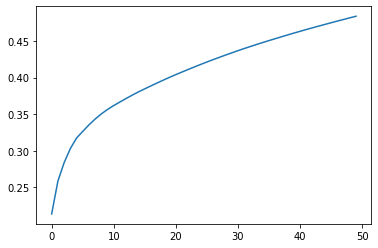

In [53]:
plt.plot(np.cumsum((s**2)[0:50])/np.sum(s**2))

In [54]:
np.dot(v[:,2], v[:,100])

-9.194034422677078e-17

In [132]:
df_alc_svd = np.matmul(df_full_res.to_numpy(), v[:,0:10])
df_alc_svd = pd.DataFrame(df_alc_svd, columns = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10'])
df_alc_svd.shape
df_alc_svd['alc_name'] = df_revs_text['alc_name']
df_alc_svd = pd.merge(df_alc_svd, df_revs_fin, "left", on = "alc_name")
df_alc_svd.sample(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,alc_name,alc_type,Brand,Flavor
1884,0.013096,0.032685,0.035262,-0.011332,0.027852,0.015107,0.034344,0.019295,0.021352,0.011611,FILIBUSTER DUAL CASK FINISHED,bourbon,NaN,NaN
1951,-0.000515,0.036238,-0.032633,-0.041120,0.010659,-0.019405,-0.007532,-0.007356,0.014542,-0.014221,CAOL ILA 17 YEAR (2015 SPECIAL RELEASE),single_malt,Caol Ila,NaN
2309,0.109909,0.026027,-0.031247,-0.008465,0.050763,0.016843,-0.008085,0.012264,-0.017439,-0.044271,GLENCADAM 15 YEAR,single_malt,Glencadam,NaN
2303,-0.019312,0.074311,0.008677,-0.036139,-0.006942,0.000933,-0.025343,0.001581,-0.086479,-0.044671,SCARABUS SINGLE MALT,single_malt_peated,Scarabus,PEATY
2975,0.002287,0.016872,0.030390,-0.027910,0.023291,0.007249,0.003097,0.014450,0.007317,-0.001464,SONS OF ERIN IRISH WHISKEY,ireland_whiskey,NaN,NaN


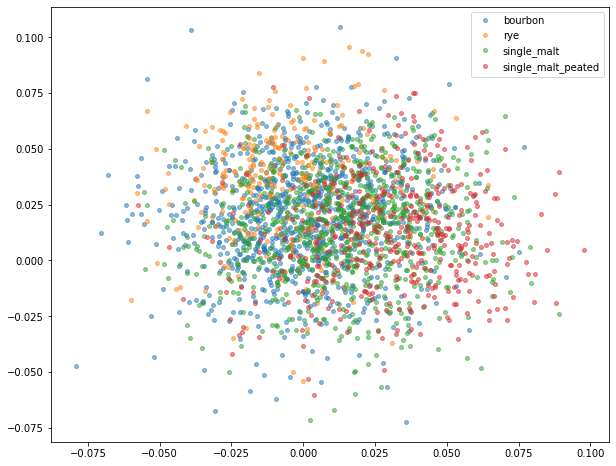

In [168]:
grouping = df_alc_svd.loc[np.isin(df_alc_svd['alc_type'], ['bourbon', 'rye', 'single_malt', 'single_malt_peated']),:]
grouping = grouping.groupby(['alc_type'])

fig, ax = plt.subplots(figsize = (10, 8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in grouping:
    ax.plot(group.V2, group.V3, marker='o', linestyle='', ms = 4, label=name, alpha = 0.5)
ax.legend()

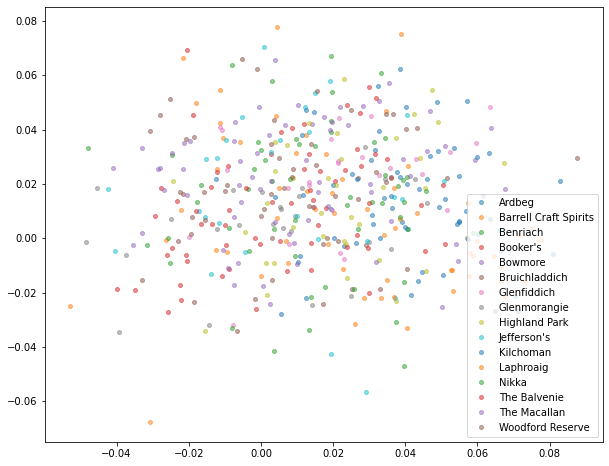

In [176]:
grouping = df_alc_svd.loc[~df_alc_svd['Brand'].isnull(),:].reset_index(drop = True)
grouping['ct_brand'] = grouping.groupby(['Brand'])['V1'].transform(lambda x: sum(~np.isnan(x)))
grouping = grouping.loc[grouping['ct_brand'] >= 25]

grouping = grouping.groupby(['Brand'])

fig, ax = plt.subplots(figsize = (10, 8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in grouping:
    ax.plot(group.V2, group.V3, marker='o', linestyle='', ms = 4, label=name, alpha = 0.5)
ax.legend()

(3112, 14)
                 Flavor   ct
70   RICH & FULL BODIED  171
28       FRUITY & SWEET  143
111        SWEET & RICH  107
103               SWEET   89
91                SPICY   72
37   FULL BODIED & RICH   58
106      SWEET & FRUITY   58
133     VANILLA & SWEET   57
18               FRUITY   53
30     FRUITY & VANILLA   50
31          FULL BODIED   48
24        FRUITY & RICH   48
67                 RICH   42
131      VANILLA & RICH   38
125             VANILLA   36


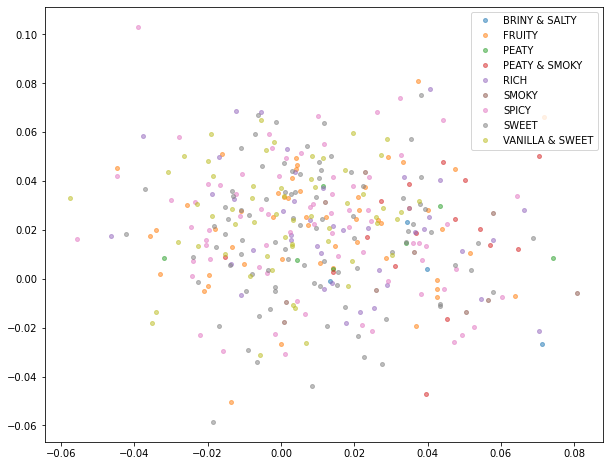

In [226]:
print(df_alc_svd.shape)
grouping = df_alc_svd.loc[~df_alc_svd['Flavor'].isnull(),:].reset_index(drop = True)
grouping['ct_flavor'] = grouping.groupby(['Flavor'])['V1'].transform(lambda x: sum(~np.isnan(x)))
top_flavors = grouping.groupby(['Flavor']).size().reset_index(name = 'ct').sort_values('ct', ascending = False)[0:15]
print(top_flavors)

# grouping = grouping.loc[np.isin(grouping['Flavor'], top_flavors['Flavor']),:]
grouping = grouping.loc[np.isin(grouping['Flavor'], ['FRUITY', 'SWEET', 'RICH', 'VANILLA & SWEET', 'SPICY', 'PEATY', 'PEATY & SMOKY', 'SMOKY', 'BRINY & SALTY'] ),:]
grouping = grouping.groupby(['Flavor'])

fig, ax = plt.subplots(figsize = (10, 8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in grouping:
    ax.plot(group.V2, group.V3, marker='o', linestyle='', ms = 4, label=name, alpha = 0.5)
ax.legend()

In [221]:
grouping = df_alc_svd.loc[~df_alc_svd['Flavor'].isnull(),:].reset_index(drop = True)
grouping['ct_flavor'] = grouping.groupby(['Flavor'])['V1'].transform(lambda x: sum(~np.isnan(x)))
top_flavors = grouping.groupby(['Flavor']).size().reset_index(name = 'ct').sort_values('ct', ascending = False)
top_flavors.loc[['SALTY' in elem for elem in top_flavors.Flavor]]

,Flavor,ct
6,BRINY & SALTY,4
77,SALTY,3
112,SWEET & SALTY,3
25,FRUITY & SALTY,2
80,SALTY & OILY,2
88,SMOKY & SALTY,1
78,SALTY & BRINY,1
79,SALTY & FRUITY,1
81,SALTY & SPICY,1


In [11]:
# WRITE A TOP 10 TYPE OF THING
# Serendipity and novelty --> specific concepts in recommender world
# Would you discover this item on your own, or is it only through us recommending it to you? 
# A measure of serendipity --> like how popular is it? 
# Find not-so-popular distillers, not-so-popular whiskeys, a DIFFERENT whiskey from the alc_type
# Inverse Zipf dist. --> boosting things low on tail for recommending
# Slope1 collaborative filtering --> it's in Surprise

In [ ]:
'''
Generating a top 10 list, top 5 list etc.
So, WEIGHT the error based off of what the actual rating of the user is. 
e.g. If average rating of user = 3 but they actually rate a thing 1.5, that's too low and we don't care. 
Concordant pairs --> another useful metric for recommenders
'''

In [294]:
### If estimate is higher --> fine. If estimate is lower --> penalty
### % of items recommended / total actual items user likes --> "recall"
### % of items actually liked / total items recommended --> "precision"
### Recommended items versus relevant items
### Serendipity / novelty --> look at list
### How to define serendipity? At USER level, pick distilleries that are less frequently rated by them / pick alc_types less frequently rated
### MATRIX FAC!!!! SGD based or ALS. SVD with missing values. NNMF
### Content-based?
### NFA applications --> recommending teams for a module
### MULTI-DIMENSIONAL RECOMMENDATION MATRICES? Ratings over time --> treated as a time series
### RATINGS VS RANKINGS ACCURACY